## baseline lightning trainer notebook

Created on: Wednesday March 16th, 2022  
Created by: Jacob Alexander Rose  

In [1]:
85/15

5.666666666666667

In [1]:
%load_ext autoreload
%autoreload 2

import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["WANDB_NOTEBOOK_NAME"] = "DEV notebook -- baseline_lightning_trainer-2.ipynb"


from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


import pandas as pd
from pathlib import Path
from icecream import ic
from rich import print as pp
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# from imutils.big.datamodule import Herbarium2022DataModule, Herbarium2022Dataset
from imutils.ml.data.datamodule import Herbarium2022DataModule, Herbarium2022Dataset
from imutils.ml.utils.etl_utils import ETL

import pytorch_lightning as pl
from torchvision import transforms as T
import argparse
import imutils
from hydra.experimental import compose, initialize, initialize_config_dir
import hydra
from omegaconf import DictConfig, OmegaConf
from typing import *
default_reader = None
import torchmetrics

from imutils.ml.models.pl import classifier

from imutils.ml.utils.experiment_utils import configure_callbacks, configure_loggers, configure_trainer

import matplotlib.pyplot as plt
import wandb
import imutils
from imutils.ml.data.datamodule import *
from imutils.ml.utils.etl_utils import ETL
from omegaconf import DictConfig, OmegaConf

from rich import print as pp

Importing imutils


## Load test config

In [2]:
# overrides = ["aug@data.datamodule.transform_cfg=auto_image_aug",
#              "data/datamodule@data=extant_leaves_family_10_512_datamodule",
#              "model_cfg.backbone.name=resnext50_32x4d"]

overrides = ["experiments=grayscale_3-channel",
             "data/datamodule@data=herbarium2022-res_512_datamodule",
             "data.datamodule.label_col=family",
             # "data/datamodule@data=extant_leaves_family_10_512_datamodule",
             "model_cfg.backbone.name=resnext50_32x4d",
             "hp.batch_size=16",
             "data.datamodule.num_workers=0",
             "train.pl_trainer.strategy=dp"]
             # "train/pl_trainer/strategy@train.pl_trainer=dp"]

# overrides = ["data/datamodule@data=herbarium2022-res_512_datamodule",
#           "model_cfg.backbone.name=resnext50_32x4d"]
          # "+train.pl_trainer.limit_train_batches=2",
          # "hp.batch_size=16",
          # "hp.resolution=224",
          # "+train.pl_trainer.limit_val_batches=2",
          # "train.pl_trainer.log_every_n_steps=10",
          # "train.pl_trainer.devices=1",
          # "train.pl_trainer.strategy=null",
          # 'model_cfg/loss=class-balanced-ce-loss',
          # "model_cfg.loss.beta=0.99",
          # "data.datamodule.transform_cfg.skip_augmentations=true"],

In [3]:
from imutils.ml.utils.experiment_utils import (configure_callbacks,
                                               configure_loggers,
                                               configure_trainer,
                                               configure_loss_func)
import hydra


config_path = os.path.dirname(imutils.ml.BASE_ML_CONF_PATH)
config_name = os.path.basename(imutils.ml.BASE_ML_CONF_PATH)
print(config_path, config_name)

cfg = ETL.init_structured_config(config_name = config_name,
                                 config_path = config_path,
                                 job_name = "demo",
                                 dataclass_type= None,
                                 overrides=overrides,
                                 cfg = None)

OmegaConf.set_struct(cfg, False)
# Hydra run directory
try:
    hydra_dir = Path(HydraConfig.get().run.dir)
except Exception as e:
    print(e)
    hydra_dir = os.getcwd()


hydra_dir = cfg.core.experiments_root_dir #"/media/data/jacob/GitHub/image-utils/imutils/ml/hydra_experiments/2022-03-24/07-35-17"


if not cfg.get("hydra"):
    cfg.update({"hydra":{"run":{"dir":hydra_dir}},
                "run_output_dir":hydra_dir})
    print(cfg.hydra.run.dir)

# print(OmegaConf.to_yaml(cfg.hydra))#, resolve=True, sort_keys=True))
pp(OmegaConf.to_container(cfg, resolve=True))

/media/data_cifs/projects/prj_fossils/users/jacob/github/image-utils/imutils/ml/conf base_conf.yaml
name 'HydraConfig' is not defined
/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/herbarium2022


{
    'core': {
        'dataset_name': 'herbarium2022_512',
        'backbone_name': 'resnext50_32x4d',
        'name': 'herbarium2022_512__resnext50_32x4d',
        'version': '0.0.1',
        'experiments_root_dir': 
'/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/herbarium2022',
        'tags': ['herbarium2022', 'kaggle']
    },
    'seed': 42,
    'run_output_dir': 
'/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/herbarium2022',
    'checkpoint_dir': 
'/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/herbarium2022/ckpts',
    'ckpt_path': None,
    'execution_list': {'print_cfg': True, 'auto_lr_tune': True, 'model_fit': True},
    'hp': {
        'num_classes': 272,
        'batch_size': 16,
        'preprocess_size': 256,
        'resolution': 224,
        'num_channels': 3,
        'to_grayscale': True,
        'warmup_epochs': 3,
        'max_epochs': 30,
        'lr': 0.001,
        'freeze_backbone': False,
        'freeze_backbone_up_to': -1,
        'load_from_checkpoint': False
    },
    'logging': {
        'log_model_summary': True,
        'log_dataset_summary': True,
        'max_batches_to_log': 2,
        'n_elements_to_log': 64,
        'normalize_visualization': True,
        'val_check_interval': 1.0,
        'progress_bar_refresh_rate': 10,
        'wandb': {
            'project': 'herbarium2022',
            'entity': 'jrose',
            'name': 'herbarium2022_512__resnext50_32x4d',
            'group': 'herbarium2022_512',
            'log_model': True,
            'tags': ['herbarium2022', 'kaggle']
        }
    },
    'optim': {
        'optimizer': {
            'eps': 1e-08,
            '_target_': 'torch.optim.Adam',
            'lr': 0.001,
            'betas': [0.9, 0.999],
            'weight_decay': 0.0
        },
        'lr_scheduler': {
            '_target_': 'pl_bolts.optimizers.lr_scheduler.LinearWarmupCosineAnnealingLR',
            'warmup_epochs': 3,
            'max_epochs': 30,
            'warmup_start_lr': 0.0001,
            'eta_min': 1e-06,
            'last_epoch': -1
        },
        'exclude_bn_bias': True,
        'use_lr_scheduler': True
    },
    'pretrain': {
        'lr_tuner': {
            'hparams_path': '/media/data_cifs/projects/prj_fossils/users/jacob/experiments/20
22/herbarium2022/pretrain/lr_tuner_hparams.yaml',
            'tuner': {
                'min_lr': 1e-08,
                'max_lr': 1.0,
                'num_training': 100,
                'mode': 'exponential',
                'early_stop_threshold': 10.0
            },
            'pl_trainer': {
                '_target_': 'pytorch_lightning.Trainer',
                'precision': 16,
                'enable_progress_bar': True,
                'devices': 1,
                'accelerator': 'gpu',
                'deterministic': True,
                'benchmark': True,
                'auto_select_gpus': True,
                'auto_lr_find': True,
                'max_epochs': 100
            }
        }
    },
    'data': {
        'num_classes': {
            'scientificName': 15501,
            'Species': 15501,
            'genus': 2564,
            'family': 272,
            'institution_id': 48
        },
        'datamodule': {
            '_target_': 'imutils.ml.data.datamodule.Herbarium2022DataModule',
            'name': 'herbarium2022_512',
            'catalog_dir': 
'/media/data/home/jrose3/data_cache/herbarium-2022-fgvc9_resize-512/catalogs',
            'label_col': 'family',
            'train_size': 0.8,
            'shuffle': True,
            'seed': 14,
            'batch_size': 16,
            'num_workers': 0,
            'pin_memory': True,
            'persistent_workers': False,
            'transform_cfg': {
                'preprocess_size': 256,
                'resolution': 224,
                'normalization': {
                    'mean': [0.485, 0.456, 0.406],
                    'std': [0.229, 0.224, 0.2

## Continued Training

* Observation:

In [5]:
pp(OmegaConf.to_container(cfg.model_cfg, resolve=True))

{
    '_target_': 'imutils.ml.models.pl.classifier.LitClassifier',
    'backbone': {
        'model_repo': 'timm',
        'name': 'resnext50_32x4d',
        'pretrained': True,
        'freeze_backbone': False
    },
    'head': {
        'num_classes': 272,
        'pool_size': 1,
        'pool_type': 'avg',
        'head_type': 'linear',
        'hidden_size': 512,
        'dropout_p': 0.3
    },
    'name': 'resnext50_32x4d',
    'sync_dist': False,
    'log_images_freq': 1000,
    'resolution': 224,
    'num_channels': 3,
    'input_shape': [3, 224, 224],
    'loss': {'_target_': 'torch.nn.CrossEntropyLoss'}
}

In [9]:
hydra.utils.log.info(f"Instantiating <{cfg.data.datamodule._target_}>")
datamodule = hydra.utils.instantiate(
    cfg.data.datamodule, _recursive_=False
)

pp(datamodule.cfg)


if cfg.execution_list.model_fit:

    hydra.utils.log.info(f"Executing train stage: model_fit")

    hydra.utils.log.info(f"Instantiating <{cfg.data.datamodule._target_}>")
    datamodule = hydra.utils.instantiate(
        cfg.data.datamodule, _recursive_=False
    )
    datamodule.setup()

    loss_func = configure_loss_func(cfg, targets=datamodule.train_dataset.df.y)

# logging.warning("1. Before model, before trainer")
hydra.utils.log.info(f"Instantiating <{cfg.model_cfg._target_}>")
# model: pl.LightningModule = hydra.utils.instantiate(cfg.model, cfg=cfg, _recursive_=False)
model = imutils.ml.models.pl.classifier.LitClassifier(cfg=cfg, #model_cfg=cfg.model_cfg,
                                                      loss_func=cfg.model_cfg.loss)

ic| subset: 'train'
    num_samples: 537453
    num_batches: 33591
    self.num_classes: 272
    self.batch_size: 16
ic| subset: 'val'
    num_samples: 134364
    num_batches: 8398
    self.num_classes: 272
    self.batch_size: 16
ic| subset: 'test'
    num_samples: 210407
    num_batches: 13151
    self.num_classes: 272
    self.batch_size: 16


Herbarium2022DataModuleConfig(
    catalog_dir='/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_res
ize-512/catalogs/splits/train_size-0.8',
    label_col='family',
    train_size=0.8,
    shuffle=True,
    seed=14,
    batch_size=16,
    num_workers=0,
    pin_memory=True,
    persistent_workers=False,
    transform_cfg={'preprocess': {'train': {'resize': 512}, 'val': {'resize': 256}, 'test': 
{'resize': 256}}, 'batch_transform': {'train': {'random_resize_crop': 224}, 'val': 
{'center_crop': 224}, 'test': {'center_crop': 224}}, 'normalize': [[0.485, 0.456, 0.406], 
[0.229, 0.224, 0.225]], 'preprocess_size': 256, 'resolution': 224, 'normalization': {'mean': 
[0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}, 'skip_augmentations': False, 
'channels': {'to_grayscale': True, 'num_output_channels': 3}, 'train': {'smallest_max_size': 
{'_target_': 'albumentations.SmallestMaxSize', 'max_size': 256, 'p': 1.0}, 
'shift_scale_rotate': {'_target_': 'albumentations.ShiftScaleRotate', 'shift_limit': 0.05, 
'scale_limit': 0.05, 'rotate_limit': 45, 'p': 0.5}, 'random_crop': {'_target_': 
'albumentations.RandomCrop', 'height': 224, 'width': 224, 'p': 1.0}, 
'random_brightness_contrast': {'_target_': 'albumentations.RandomBrightnessContrast', 
'brightness_limit': 0.2, 'contrast_limit': 0.2, 'brightness_by_max': False, 'always_apply': 
False, 'p': 0.5}, 'normalize': {'_target_': 'albumentations.Normalize', 'mean': [0.485, 
0.456, 0.406], 'std': [0.229, 0.224, 0.225], 'p': 1.0}, 'to_tensor': {'_target_': 
'albumentations.pytorch.ToTensorV2'}}, 'val': {'smallest_max_size': {'_target_': 
'albumentations.SmallestMaxSize', 'max_size': 256, 'p': 1.0}, 'center_crop': {'_target_': 
'albumentations.CenterCrop', 'height': 224, 'width': 224, 'p': 1.0}, 'normalize': 
{'_target_': 'albumentations.Normalize', 'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224,
0.225], 'p': 1.0}, 'to_tensor': {'_target_': 'albumentations.pytorch.ToTensorV2'}}, 'test': 
{'smallest_max_size': {'_target_': 'albumentations.SmallestMaxSize', 'max_size': 256, 'p': 
1.0}, 'center_crop': {'_target_': 'albumentations.CenterCrop', 'height': 224, 'width': 224, 
'p': 1.0}, 'normalize': {'_target_': 'albumentations.Normalize', 'mean': [0.485, 0.456, 
0.406], 'std': [0.229, 0.224, 0.225], 'p': 1.0}, 'to_tensor': {'_target_': 
'albumentations.pytorch.ToTensorV2'}}},
    to_grayscale=True,
    num_channels=3,
    remove_transforms=False
)

ic| subset: 'train'
    num_samples: 537453
    num_batches: 33591
    self.num_classes: 272
    self.batch_size: 16
ic| subset: 'val'
    num_samples: 134364
    num_batches: 8398
    self.num_classes: 272
    self.batch_size: 16
ic| subset: 'test'
    num_samples: 210407
    num_batches: 13151
    self.num_classes: 272
    self.batch_size: 16
ic| subset: 'train'
    num_samples: 537453
    num_batches: 33591
    self.num_classes: 272
    self.batch_size: 16
ic| subset: 'val'
    num_samples: 134364
    num_batches: 8398
    self.num_classes: 272
    self.batch_size: 16
ic| subset: 'test'
    num_samples: 210407
    num_batches: 13151
    self.num_classes: 272
    self.batch_size: 16


Initializing weights of the model head.
input_size: (1, 3, 224, 224)


In [10]:
pp(datamodule.cfg)

Herbarium2022DataModuleConfig(
    catalog_dir='/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_res
ize-512/catalogs/splits/train_size-0.8',
    label_col='family',
    train_size=0.8,
    shuffle=True,
    seed=14,
    batch_size=16,
    num_workers=0,
    pin_memory=True,
    persistent_workers=False,
    transform_cfg={'preprocess': {'train': {'resize': 512}, 'val': {'resize': 256}, 'test': 
{'resize': 256}}, 'batch_transform': {'train': {'random_resize_crop': 224}, 'val': 
{'center_crop': 224}, 'test': {'center_crop': 224}}, 'normalize': [[0.485, 0.456, 0.406], 
[0.229, 0.224, 0.225]], 'preprocess_size': 256, 'resolution': 224, 'normalization': {'mean': 
[0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}, 'skip_augmentations': False, 
'channels': {'to_grayscale': True, 'num_output_channels': 3}, 'train': {'smallest_max_size': 
{'_target_': 'albumentations.SmallestMaxSize', 'max_size': 256, 'p': 1.0}, 
'shift_scale_rotate': {'_target_': 'albumentations.ShiftScaleRotate', 'shift_limit': 0.05, 
'scale_limit': 0.05, 'rotate_limit': 45, 'p': 0.5}, 'random_crop': {'_target_': 
'albumentations.RandomCrop', 'height': 224, 'width': 224, 'p': 1.0}, 
'random_brightness_contrast': {'_target_': 'albumentations.RandomBrightnessContrast', 
'brightness_limit': 0.2, 'contrast_limit': 0.2, 'brightness_by_max': False, 'always_apply': 
False, 'p': 0.5}, 'normalize': {'_target_': 'albumentations.Normalize', 'mean': [0.485, 
0.456, 0.406], 'std': [0.229, 0.224, 0.225], 'p': 1.0}, 'to_tensor': {'_target_': 
'albumentations.pytorch.ToTensorV2'}}, 'val': {'smallest_max_size': {'_target_': 
'albumentations.SmallestMaxSize', 'max_size': 256, 'p': 1.0}, 'center_crop': {'_target_': 
'albumentations.CenterCrop', 'height': 224, 'width': 224, 'p': 1.0}, 'normalize': 
{'_target_': 'albumentations.Normalize', 'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224,
0.225], 'p': 1.0}, 'to_tensor': {'_target_': 'albumentations.pytorch.ToTensorV2'}}, 'test': 
{'smallest_max_size': {'_target_': 'albumentations.SmallestMaxSize', 'max_size': 256, 'p': 
1.0}, 'center_crop': {'_target_': 'albumentations.CenterCrop', 'height': 224, 'width': 224, 
'p': 1.0}, 'normalize': {'_target_': 'albumentations.Normalize', 'mean': [0.485, 0.456, 
0.406], 'std': [0.229, 0.224, 0.225], 'p': 1.0}, 'to_tensor': {'_target_': 
'albumentations.pytorch.ToTensorV2'}}},
    to_grayscale=True,
    num_channels=3,
    remove_transforms=False
)

In [ ]:
# num_classes: 
#     scientificName: 15501
#     genus: 2564
#     family: 272
#     institution_id: 48

In [9]:
datamodule.taxonomy.df.columns

# datamodule.train_dataset.taxonomy

datamodule.taxonomy.df.value_counts()#groupby("institution_id").head(1).shape

In [10]:
# datamodule.train_dataset.taxonomy

datamodule.taxonomy.df.describe(include='all')

,index,path,y,family,genus,species,collection,catalog_number,Species
count,9189.000000,9189,9189.0,9189,9189,9189,9189,9189,9189
unique,NaN,9189,94.0,94,2896,4838,4,9189,9189
top,NaN,/media/data_cifs/projects/prj_fossils/data/pro...,35.0,Fabaceae,Quercus,sp,Wolfe,Wolfe_614,Sabia javanica
freq,NaN,1,878.0,878,138,46,6082,1,1
mean,11768.065078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,6743.295617,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,6127.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,11682.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,17601.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# datamodule.train_dataset.taxonomy
datamodule.taxonomy.df.groupby("genus").head(1)#.shape

,idx,Species,path,y,category_id,genus_id,institution_id,image_id,file_name,scientificName,family,genus,species,collectionCode
0,675825,Rhododendron minus,/media/data_cifs/projects/prj_fossils/data/raw...,91,12468,2053,13,12468__100,124/68/12468__100.jpg,Rhododendron minus Michx.,Ericaceae,Rhododendron,minus,COLO
1,435610,Kelseya uniflora,/media/data_cifs/projects/prj_fossils/data/raw...,219,8040,1311,36,08040__027,080/40/08040__027.jpg,Kelseya uniflora Rydb.,Rosaceae,Kelseya,uniflora,NY
2,738934,Sisyrinchium angustifolium,/media/data_cifs/projects/prj_fossils/data/raw...,122,13638,2225,25,13638__079,136/38/13638__079.jpg,Sisyrinchium angustifolium Mill.,Iridaceae,Sisyrinchium,angustifolium,IDS
3,353726,Galium concinnum,/media/data_cifs/projects/prj_fossils/data/raw...,220,6569,1005,36,06569__061,065/69/06569__061.jpg,Galium concinnum Torr. & A.Gray,Rubiaceae,Galium,concinnum,NY
4,371993,Guettarda elliptica,/media/data_cifs/projects/prj_fossils/data/raw...,220,6896,1081,52,06896__047,068/96/06896__047.jpg,Guettarda elliptica Sw.,Rubiaceae,Guettarda,elliptica,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227180,263163,Dimerandra emarginata,/media/data_cifs/projects/prj_fossils/data/raw...,179,4881,775,38,04881__020,048/81/04881__020.jpg,Dimerandra emarginata (G.Mey.) Hoehne,Orchidaceae,Dimerandra,emarginata,P
234067,807784,Typhonium blumei,/media/data_cifs/projects/prj_fossils/data/raw...,16,14906,2475,21,14906__010,149/06/14906__010.jpg,Typhonium blumei Nicolson & Sivad.,Araceae,Typhonium,blumei,GH
280694,815506,Varilla texana,/media/data_cifs/projects/prj_fossils/data/raw...,23,15044,2499,36,15044__007,150/44/15044__007.jpg,Varilla texana A.Gray,Asteraceae,Varilla,texana,NY
302392,626724,Pleiostachya pruinosa,/media/data_cifs/projects/prj_fossils/data/raw...,148,11583,1898,38,11583__011,115/83/11583__011.jpg,Pleiostachya pruinosa (Regel) K.Schum.,Marantaceae,Pleiostachya,pruinosa,P


In [7]:
# datamodule.train_dataset.taxonomy
dir(datamodule.taxonomy)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_setup_lookup_table',
 'as_wandb_table',
 'df',
 'from_pyarrow',
 'load_from_state_dict',
 'lookup_table',
 'prepare_columns',
 'query_rows_by_value',
 'smallest_taxon_col',
 'state_dict',
 'to_pyarrow']

In [8]:
datamodule.train_dataset.df

,idx,Species,path,y,category_id,genus_id,institution_id,image_id,file_name,scientificName,family,genus,species,collectionCode
0,675825,Rhododendron minus,/media/data_cifs/projects/prj_fossils/data/raw...,91,12468,2053,13,12468__100,124/68/12468__100.jpg,Rhododendron minus Michx.,Ericaceae,Rhododendron,minus,COLO
1,435610,Kelseya uniflora,/media/data_cifs/projects/prj_fossils/data/raw...,219,8040,1311,36,08040__027,080/40/08040__027.jpg,Kelseya uniflora Rydb.,Rosaceae,Kelseya,uniflora,NY
2,738934,Sisyrinchium angustifolium,/media/data_cifs/projects/prj_fossils/data/raw...,122,13638,2225,25,13638__079,136/38/13638__079.jpg,Sisyrinchium angustifolium Mill.,Iridaceae,Sisyrinchium,angustifolium,IDS
3,353726,Galium concinnum,/media/data_cifs/projects/prj_fossils/data/raw...,220,6569,1005,36,06569__061,065/69/06569__061.jpg,Galium concinnum Torr. & A.Gray,Rubiaceae,Galium,concinnum,NY
4,371993,Guettarda elliptica,/media/data_cifs/projects/prj_fossils/data/raw...,220,6896,1081,52,06896__047,068/96/06896__047.jpg,Guettarda elliptica Sw.,Rubiaceae,Guettarda,elliptica,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537448,584511,Penstemon venustus,/media/data_cifs/projects/prj_fossils/data/raw...,197,10801,1793,47,10801__086,108/01/10801__086.jpg,Penstemon venustus Douglas,Plantaginaceae,Penstemon,venustus,SRP
537449,448007,Lepidium thurberi,/media/data_cifs/projects/prj_fossils/data/raw...,34,8255,1364,36,08255__041,082/55/08255__041.jpg,Lepidium thurberi Wooton,Brassicaceae,Lepidium,thurberi,NY
537450,19201,Aldama cordifolia,/media/data_cifs/projects/prj_fossils/data/raw...,23,359,66,36,00359__013,003/59/00359__013.jpg,Aldama cordifolia (A.Gray) E.E.Schill. & Panero,Asteraceae,Aldama,cordifolia,NY
537451,627564,Pleurothallis ruscifolia,/media/data_cifs/projects/prj_fossils/data/raw...,179,11599,1906,36,11599__053,115/99/11599__053.jpg,Pleurothallis ruscifolia (Jacq.) R.Br.,Orchidaceae,Pleurothallis,ruscifolia,NY


In [4]:


# logging.warning("2. After model, before trainer")
# ic(torch.cuda.current_device())	
# ic(torch.cuda.get_device_name(0))
wandb_logger = configure_loggers(cfg=cfg, model=model)
callbacks: List[pl.Callback] = configure_callbacks(cfg=cfg.train)	
hydra.utils.log.info(f"Instantiating the Trainer")
pp(OmegaConf.to_container(cfg.train.pl_trainer))
trainer = configure_trainer(cfg,
                            callbacks=callbacks,
                            logger=wandb_logger)
# logging.warning("3. After model, after trainer, before fit")
# ic(torch.cuda.current_device())
num_samples = len(datamodule.train_dataset)
num_classes = cfg.model_cfg.head.num_classes
batch_size = datamodule.batch_size #["train"]
hydra.utils.log.info("Starting training with {} classes across {} images in batches of {} images each.".format(
    num_classes,
    num_samples,
    batch_size))

In [4]:
from imutils.ml.models.pl.classifier import LitClassifier

In [5]:
ckpt_path = "/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/herbarium2022/hydra_experiments/2022-04-01/21-13-25/ckpts/epoch=22-val_loss=1.316-val_macro_F1=0.720/model_weights.ckpt"

model = LitClassifier.load_from_checkpoint(checkpoint_path=ckpt_path,
                                           cfg=cfg)
                               # map_location = lambda x: x)

Initializing weights of the model head.
input_size: (1, 3, 448, 448)
Initializing weights of the model head.
input_size: (1, 3, 224, 224)


In [10]:
model.summarize_model()#2)

input_size: (1, 3, 224, 224)


In [15]:
model.net.head[-1]

Linear(in_features=2048, out_features=94, bias=True)

In [7]:
dir(model)

['CHECKPOINT_HYPER_PARAMS_KEY',
 'CHECKPOINT_HYPER_PARAMS_NAME',
 'CHECKPOINT_HYPER_PARAMS_TYPE',
 'T_destination',
 '_DeviceDtypeModuleMixin__update_properties',
 '_LightningModule__check_allowed',
 '_LightningModule__check_not_nested',
 '_LightningModule__to_tensor',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__jit_unused_properties__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_apply_batch_transfer_handler',
 '_auto_collect_arguments',
 '_automatic_optimization',
 '_backward_hooks',
 '_buffers',
 '_call_impl',
 '_current_fx_name',
 '_device',
 '_dtype',
 '_example_input_array',
 '_forward_hooks',
 '_forward

In [17]:
# model.cfg
pp(OmegaConf.to_container(model.cfg))

{
    'core': {
        'name': 'Experiment #21 (2022-04-01)',
        'version': '0.0.1',
        'experiments_root_dir': 
'/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/herbarium2022',
        'tags': ['herbarium2022', 'kaggle']
    },
    'execution_list': {'auto_lr_tune': True, 'model_fit': True},
    'hp': {
        'batch_size': 24,
        'preprocess_size': 'None',
        'resolution': 448,
        'num_channels': 3,
        'warmup_epochs': 5,
        'max_epochs': 30,
        'lr': 0.002,
        'freeze_backbone': False,
        'freeze_backbone_up_to': 0
    },
    'seed': 42,
    'run_output_dir': '/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/her
barium2022/hydra_experiments/2022-04-01/21-13-25',
    'checkpoint_dir': '/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/her
barium2022/hydra_experiments/2022-04-01/21-13-25/ckpts',
    'model_cfg': {
        '_target_': 'imutils.ml.models.pl.classifier.LitClassifier',
        'backbone': {
            'model_repo': 'timm',
            'name': 'resnext50_32x4d',
            'pretrained': True,
            'freeze_backbone': False
        },
        'head': {
            'num_classes': 15501,
            'pool_size': 1,
            'pool_type': 'avg',
            'head_type': 'linear',
            'hidden_size': 512,
            'dropout_p': 0.3
        },
        'name': 'resnext50_32x4d',
        'loss': {'_target_': 'torch.nn.CrossEntropyLoss'},
        'resolution': 448,
        'num_channels': 3,
        'input_shape': [3, 448, 448]
    },
    'optim': {
        'optimizer': {
            '_target_': 'torch.optim.Adam',
            'lr': 0.002,
            'betas': [0.9, 0.999],
            'eps': 1e-08,
            'weight_decay': 5e-06
        },
        'exclude_bn_bias': True,
        'use_lr_scheduler': True,
        'lr_scheduler': {
            '_target_': 'pl_bolts.optimizers.lr_scheduler.LinearWarmupCosineAnnealingLR',
            'warmup_epochs': 5,
            'max_epochs': 30,
            'warmup_start_lr': 2.7673238836757465e-06,
            'eta_min': 1e-06,
            'last_epoch': -1
        }
    },
    'train': {
        'deterministic': False,
        'random_seed': 42,
        'pl_trainer': {
            '_target_': 'pytorch_lightning.Trainer',
            'fast_dev_run': False,
            'accelerator': 'gpu',
            'devices': 4,
            'precision': 16,
            'enable_model_summary': True,
            'log_every_n_steps': 15,
            'max_epochs': 50,
            'accumulate_grad_batches': 2,
            'strategy': {
                '_target_': 'pytorch_lightning.plugins.DDPPlugin',
                'find_unused_parameters': False
            },
            'profiler': 'simple'
        },
        'freeze_backbone': False,
        'freeze_backbone_up_to': False,
        'callbacks': {
            'kwargs': {'monitor': {'metric': 'val_macro_F1', 'mode': 'max'}},
            'lr_monitor': {
                '_target_': 'pytorch_lightning.callbacks.LearningRateMonitor',
                'logging_interval': 'step',
                'log_momentum': False
            },
            'early_stopping': {
                '_target_': 'pytorch_lightning.callbacks.early_stopping.EarlyStopping',
                'monitor': 'val_macro_F1',
                'patience': 15,
                'verbose': True,
                'mode': 'max',
                'min_delta': 0.05
            },
            'model_checkpoint': {
                '_target_': 'pytorch_lightning.callbacks.ModelCheckpoint',
                'monitor': 'val_macro_F1',
                'save_top_k': 2,
                'save_last': True,
                'mode': 'max',
                'verbose': True,
                'dirpath': '/media/data_cifs/projects/prj_fossils/users/jacob/experiments/202
2/herbarium2022/hydra_experiments/2022-04-01/21-13-25/ckpts',
                'filename': '{epoch:02d}-{val_loss:.3f}-{val_macro_F1:

In [13]:
pp(OmegaConf.to_container(cfg))

{
    'core': {
        'dataset_name': '${data.datamodule.name}',
        'backbone_name': '${model_cfg.name}',
        'name': '${.dataset_name}__${.backbone_name}',
        'version': '0.0.1',
        'experiments_root_dir': 
'/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/herbarium2022',
        'tags': ['herbarium2022', 'kaggle']
    },
    'seed': 42,
    'run_output_dir': 
'/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/herbarium2022',
    'checkpoint_dir': '${run_output_dir}/ckpts',
    'ckpt_path': None,
    'execution_list': {'print_cfg': True, 'auto_lr_tune': True, 'model_fit': True},
    'hp': {
        'num_classes': '${data.num_classes}',
        'batch_size': 16,
        'preprocess_size': 256,
        'resolution': 224,
        'num_channels': 3,
        'to_grayscale': True,
        'warmup_epochs': 3,
        'max_epochs': 30,
        'lr': 0.001,
        'freeze_backbone': False,
        'freeze_backbone_up_to': -1,
        'load_from_pretrained': False
    },
    'logging': {
        'log_model_summary': True,
        'log_dataset_summary': True,
        'max_batches_to_log': 2,
        'n_elements_to_log': 64,
        'normalize_visualization': True,
        'val_check_interval': 1.0,
        'progress_bar_refresh_rate': 10,
        'wandb': {
            'project': 'herbarium2022',
            'entity': 'jrose',
            'name': '${core.name}',
            'group': '${data.datamodule.name}',
            'log_model': True,
            'tags': '${core.tags}'
        }
    },
    'optim': {
        'optimizer': {
            'eps': 1e-08,
            '_target_': 'torch.optim.Adam',
            'lr': '${hp.lr}',
            'betas': [0.9, 0.999],
            'weight_decay': 0.0
        },
        'lr_scheduler': {
            '_target_': 'pl_bolts.optimizers.lr_scheduler.LinearWarmupCosineAnnealingLR',
            'warmup_epochs': '${hp.warmup_epochs}',
            'max_epochs': '${hp.max_epochs}',
            'warmup_start_lr': 0.0001,
            'eta_min': 1e-06,
            'last_epoch': -1
        },
        'exclude_bn_bias': True,
        'use_lr_scheduler': True
    },
    'pretrain': {
        'lr_tuner': {
            'hparams_path': '${run_output_dir}/pretrain/lr_tuner_hparams.yaml',
            'tuner': {
                'min_lr': 1e-08,
                'max_lr': 1.0,
                'num_training': 100,
                'mode': 'exponential',
                'early_stop_threshold': 10.0
            },
            'pl_trainer': {
                '_target_': 'pytorch_lightning.Trainer',
                'precision': 16,
                'enable_progress_bar': True,
                'devices': 1,
                'accelerator': 'gpu',
                'deterministic': True,
                'benchmark': True,
                'auto_select_gpus': True,
                'auto_lr_find': True,
                'max_epochs': 100
            }
        }
    },
    'data': {
        'num_classes': 94,
        'datamodule': {
            '_target_': 'imutils.ml.data.datamodule.ExtantLeavesDataModule',
            'name': 'extant_leaves_family_10_512',
            'catalog_dir': '/media/data_cifs/projects/prj_fossils/users/jacob/data/leavesdb-v
1_1/Extant_Leaves_family_10_512/splits/splits=(0.5,0.2,0.3)',
            'label_col': 'family',
            'splits': [0.5, 0.2, 0.3],
            'shuffle': True,
            'seed': 14,
            'batch_size': '${hp.batch_size}',
            'num_workers': 0,
            'pin_memory': True,
            'persistent_workers': False,
            'transform_cfg': {
                'preprocess_size': 256,
                'resolution': 224,
                'normalization': {
                    'mean': [0.485, 0.456, 0.406],
                    'std': [0.229, 0.224, 0.225]
                },
                'skip_augmentations': False,
                'channels': {
                    'to_grayscale': '${hp.to_grayscale}',
              

In [5]:
cat_seq = datamodule.train_dataset.df.y

from empiricaldist import Pmf  # pip install empiricaldist


pmf_dist = Pmf.from_seq(cat_seq, normalize=False)

<AxesSubplot:>

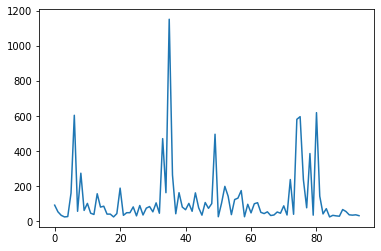

In [8]:
pmf_dist.plot()

In [9]:
from empiricaldist import Cdf

In [18]:
dist = datamodule.train_dataset.df.y

cdf_dist = Cdf.from_seq(dist, normalize=False)

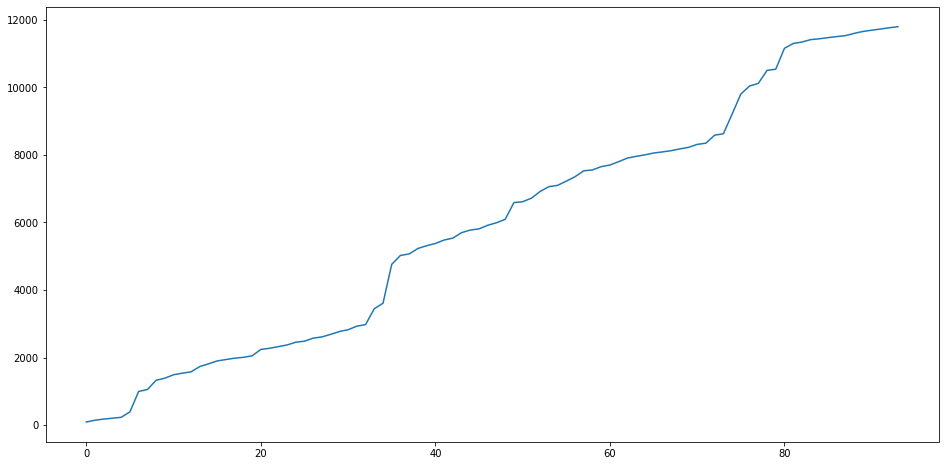

In [19]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(cdf_dist)
# plt.show();

In [26]:
cdf_dist[2]

180

In [13]:
dist_counts = dist.value_counts()

In [17]:
dist_counts.median()

66.5

In [15]:
# Calculate the median price
median_count = dist_counts.median()
# Get the frequency for median
median_prob = dist_counts[median_count]

# 25th percentile
# percentile_25th = dist.describe()['25%']
percentile_25th = dist_counts.describe()['25%']

# Probability of 25th percentile
percentile_prob = dist_counts[percentile_25th]


fig, ax = plt.subplots(figsize=(16,8))

# PLot the CDF
ax.plot(cdf_dist)


ax.annotate(text='Median count',
            xy=(median_count, median_prob),
            xycoords='data',
            textcoords='offset points',
            xytext=(70, 200),
            fontsize=15,
            arrowprops={'color': 'red'})

# Annotate 25th percentile
ax.annotate(text='25th percentile',
            xy=(percentile_25th, percentile_prob),
            xycoords='data',
            textcoords='offset points',
            xytext=(200, 0),
            fontsize=15,
            arrowprops={'color': 'red'})

ax.set(title='CDF of class counts',
       xlabel='class label',
       ylabel='Cumulative Frequency')
plt.show();

KeyError: 66.5

In [12]:
from tqdm import tqdm


def predict(datamodule, subset: str="test", device="cuda"):
    dataloader = datamodule.get_dataloader(subset=subset)
    total=len(dataloader)

    results = []
    for batch_idx, batch in tqdm(enumerate(iter(dataloader)), total=total):
        # x, y, metadata = batch
        batch[0] = batch[0].to(device)
        # image_ids = metadata['image_id']

        output = model.predict_step(batch, batch_idx)
        output["y_logit"] = output["y_logit"].cpu().detach()
        results.append(output)

        
    y_preds = np.concatenate([torch.argmax(r["y_logit"], -1).numpy() for r in tqdm(results)])
    image_ids = np.concatenate([r["image_id"] for r in results])
    
    
    predictions_df = pd.DataFrame({"Id":image_ids,
                                   "Predicted":y_preds})


# y_pred_labels = datamodule.train_dataset.label_encoder.inv_transform(y_preds)
# y_pred_labels


# def get_category_id(query):
#     return catalog[catalog.y==query].category_id.item()

# category_ids =  preds.assign(Predicted_cat_id = preds.progress_apply(lambda x: get_category_id(query=x.Predicted), axis=1))
# preds_final = category_ids.copy()
# preds_final = preds_final.drop(columns=["Predicted"]
#                               ).rename(columns={"Predicted_cat_id":"Predicted"})

100%|███████████████████████████████████████████████████████████████████████████████████████████| 8767/8767 [38:17<00:00,  3.82it/s]


In [68]:
import numpy as np
def image_stats(img: np.ndarray) -> str:
    return f"{img.mean()=:.3f}, {img.std()=:.3f}, {img.min()=:.3f}, {img.max()=:.3f}, {img.dtype=}, {img.shape=}"

In [69]:
# img = datamodule.train_dataset[0][0]

# image_stats(img.astype("float32"))

In [ ]:


datamodule.show_batch(batch_idx=10, figsize=(7,7))

In [93]:
class TaxonomyLookupTable:
    """
    Custom class designed as an interface for producing a table mapping unique taxonomy categories to their corresponding taxons above & below in the hierarchy.
    
    User passes in a dataframe containing their full data catalog (or at least a representative subset). The class takes 1 row from each unique value in the `smallest_taxon_col`, which conveniently also accomplishes the goal of having a minimum of 1 row per unique value in every other taxon above it.
    The default smallest_taxon_col is set to `Species`, which is defined as the concatenation of a `genus` and `species` column. The distinction between uppercase & lowercase `Species` vs. `species` is that 2 identical `species` names might refer to organisms in unrelated genera. The combination of `genus` with `species` is therefore guaranteed to prevent collisions in the namespace.
    
    Species->genus->family
    
    
    Features to be worked on:
    
    * Meerkat plugin for easily & dynamically visualizing images with taxonomy instance
    
    
    
    """
    def __init__(self,
                 df: pd.DataFrame,
                 smallest_taxon_col: str="Species"):
        self.df = df
        self.smallest_taxon_col = smallest_taxon_col
        self.prepare_columns()

    def prepare_columns(self):
        df = self.df
        if (
            ("Species" not in df.columns) and 
            ("genus" in df.columns) and
            ("species" in df.columns)
        ):
            df = df.assign(Species = df.apply(lambda x: " ".join([x.genus, x.species]), axis=1))

        self.df = df.groupby(self.smallest_taxon_col).head(1)


    def query_rows_by_value(self,
                            query_col: str,
                            query_value: Any) -> pd.DataFrame:
        return self.df[self.df[query_col] == query_value]

    
    def lookup_table(self,
                     query_table: Union[pd.DataFrame, pd.Series],
                     on: str="Species") -> pd.DataFrame:
        """
        Merge a query_table on the `on` column with this taxonomy table's dataframe, resulting in a new dataframe containing the query table & completed values from the lookup table.
        """
        
        if isinstance(query_table, pd.Series):
            query_table = query_table.to_frame()
            
        lookup_table = self._setup_lookup_table(lookup_on=on)

        return query_table.merge(lookup_table, how='left', on=on)


    def _setup_lookup_table(self, lookup_on: str="Species") -> pd.DataFrame:
        """
        Private method. User should call lookup_table() method instead.
        
        Removes sets of columns from taxonomy's underlying lookup table to prevent potentially invalid or irrelevant outputs.
        
        e.g. if looking up on genus or family values, any Species values will be nonsense, since there will usually be more than 1 valid Species.
        """
        drop_cols = ["catalog_number", "path", "index", "collection"]
        if lookup_on in ["y", "family", "genus"]:
            drop_cols.extend(["species", "Species"])
        if lookup_on in ["y", "family"]:
            drop_cols.extend(["genus"])
        
        drop_cols = [c for c in drop_cols if c in self.df.columns]
        lookup_table = self.df.drop(columns=drop_cols)
        return lookup_table
    
    def state_dict(self):
        return {
            "df": self.df,
            "smallest_taxon_col": smallest_taxon_col
        }
    
    @classmethod
    def load_from_state_dict(cls,
                             state_dict: Dict[str, Any]):
        return cls(**state_dict)
    

    def as_wandb_table(self) -> wandb.Table:
        return wandb.Table(dataframe=self.df)



class TaxonomyLoggerCallback(pl.Callback):
    
    def __init__(self,
                 name: str="taxonomy"):
        """
        
        todo:
            1. Add a flag for optionally logging as an artifact instead.
        
        Arguments:
            name: str, default='taxonomy'
                name under which to log the table.
        
        """
        self.name = name
        self.taxonomy_table = None
        super().__init__()
        
    def on_train_start(self, trainer, pl_module) -> None:
        
        df = trainer.datamodule.train_dataset.df
        
        self.taxonomy_table = TaxonomyLookupTable(df = df)
        
        logger = template_utils.get_wandb_logger(trainer.loggers)
        self.log_table(table=self.taxonomy_table.as_wandb_table(),
                       global_step = trainer.global_step,
                       commit=True,
                       logger=logger)
        
    @staticmethod
    def log_table(table: wandb.Table,
                  global_step: int=0,
                  commit: bool=True,
                  logger=None) -> None:

        if isinstance(logger, pl.loggers.WandbLogger):
            logger = logger.experiment
        else:
            logger = wandb

            wandb.log(
                {
                    "taxonomy.extant_family_10": table,
                    "global_step":global_step
                },
                commit=commit
            )


In [61]:
model = model.to("cpu")

df = datamodule.train_dataset.df

In [96]:
df = datamodule.val_dataset.df

In [97]:
df = df.assign(Species = df.apply(lambda x: " ".join([x.genus, x.species]), axis=1))

Species_dummy_df = df[["index", "catalog_number", "path", "collection", "Species"]]
Species_dummy_df

,index,catalog_number,path,collection,Species
0,12493,Wolfe_4352,/media/data_cifs/projects/prj_fossils/data/pro...,Wolfe,Commiphora pyracanthoides
1,6640,Wolfe_2746b,/media/data_cifs/projects/prj_fossils/data/pro...,Wolfe,Icacina claessensi
2,492,Hickey_4131,/media/data_cifs/projects/prj_fossils/data/pro...,Hickey,Pithecellobium sonorae
3,3175,Wolfe_1589,/media/data_cifs/projects/prj_fossils/data/pro...,Wolfe,Berchemia floribunda
4,20622,Wolfe_385,/media/data_cifs/projects/prj_fossils/data/pro...,Wolfe,Arytera brackenridgei
...,...,...,...,...,...
4715,5678,Wolfe_18118,/media/data_cifs/projects/prj_fossils/data/pro...,Wolfe,Salix repens
4716,4111,Wolfe_10845a,/media/data_cifs/projects/prj_fossils/data/pro...,Wolfe,Ficus mexiae
4717,20400,Wolfe_4892,/media/data_cifs/projects/prj_fossils/data/pro...,Wolfe,Aphania senegalensis
4718,11822,Wolfe_5117,/media/data_cifs/projects/prj_fossils/data/pro...,Wolfe,Mascarenhasia lanceolata


In [99]:
df.value_counts("y")

y 
35    460
80    247
6     242
75    238
74    233
     ... 
84     10
50     10
3      10
58     10
18     10
Length: 94, dtype: int64

In [100]:
len(df)

4720

In [101]:
460/4720

0.09745762711864407

In [95]:
result = taxonomy_table.lookup_table(Species_dummy_df, on="Species")
result

,index,catalog_number,path,collection,Species,y,family,genus,species
0,3359,Wolfe_614,/media/data_cifs/projects/prj_fossils/data/pro...,Wolfe,Sabia javanica,77,Sabiaceae,Sabia,javanica
1,2476,Wolfe_7800,/media/data_cifs/projects/prj_fossils/data/pro...,Wolfe,Hibbertia lucida,29,Dilleniaceae,Hibbertia,lucida
2,22262,Hickey_344,/media/data_cifs/projects/prj_fossils/data/pro...,Hickey,Alfaroa mexicana,41,Juglandaceae,Alfaroa,mexicana
3,1027,Wolfe_30106b,/media/data_cifs/projects/prj_fossils/data/pro...,Wolfe,Acacia cornigera,35,Fabaceae,Acacia,cornigera
4,22796,Wolfe_10480,/media/data_cifs/projects/prj_fossils/data/pro...,Wolfe,Malacothamnus orbiculatus,49,Malvaceae,Malacothamnus,orbiculatus
...,...,...,...,...,...,...,...,...,...
11792,12017,Wolfe_23,/media/data_cifs/projects/prj_fossils/data/pro...,Wolfe,Mahonia bealei,12,Berberidaceae,Mahonia,bealei
11793,7998,Wolfe_10240,/media/data_cifs/projects/prj_fossils/data/pro...,Wolfe,Pentas lanceolata,75,Rubiaceae,Pentas,lanceolata
11794,8743,Wolfe_13417,/media/data_cifs/projects/prj_fossils/data/pro...,Wolfe,Mascagnia multiglandulosa,48,Malpighiaceae,Mascagnia,multiglandulosa
11795,13532,Wolfe_6975,/media/data_cifs/projects/prj_fossils/data/pro...,Wolfe,Radermachera sorsogonensis,14,Bignoniaceae,Radermachera,sorsogonensis


In [86]:
result.describe(include='all')

,Species,y,family,genus,species,collection
count,11797,11797,11797,11797,11797,11797
unique,9189,94,94,2896,4838,4
top,Hymenaea courbaril,35,Fabaceae,Quercus,mexicana,Wolfe
freq,27,1151,1151,195,53,7435


In [80]:
query_df = true_Species.to_frame()

In [81]:
# dir(query_df)
query_df

,Species
0,Sabia javanica
1,Hibbertia lucida
2,Alfaroa mexicana
3,Acacia cornigera
4,Malacothamnus orbiculatus
...,...
11792,Mahonia bealei
11793,Pentas lanceolata
11794,Mascagnia multiglandulosa
11795,Radermachera sorsogonensis


In [82]:
result = query_df.merge(taxonomy_table.df, how='left', on="Species")
    # lambda x: taxonomy_table.query_rows_by_value("Species", x)[["family", "genus"]])
result

,Species,index,path,y,family,genus,species,collection,catalog_number
0,Sabia javanica,3359,/media/data_cifs/projects/prj_fossils/data/pro...,77,Sabiaceae,Sabia,javanica,Wolfe,Wolfe_614
1,Hibbertia lucida,2476,/media/data_cifs/projects/prj_fossils/data/pro...,29,Dilleniaceae,Hibbertia,lucida,Wolfe,Wolfe_7800
2,Alfaroa mexicana,22262,/media/data_cifs/projects/prj_fossils/data/pro...,41,Juglandaceae,Alfaroa,mexicana,Hickey,Hickey_344
3,Acacia cornigera,1027,/media/data_cifs/projects/prj_fossils/data/pro...,35,Fabaceae,Acacia,cornigera,Wolfe,Wolfe_30106b
4,Malacothamnus orbiculatus,22796,/media/data_cifs/projects/prj_fossils/data/pro...,49,Malvaceae,Malacothamnus,orbiculatus,Wolfe,Wolfe_10480
...,...,...,...,...,...,...,...,...,...
11792,Mahonia bealei,12048,/media/data_cifs/projects/prj_fossils/data/pro...,12,Berberidaceae,Mahonia,bealei,Wolfe,Wolfe_22
11793,Pentas lanceolata,7998,/media/data_cifs/projects/prj_fossils/data/pro...,75,Rubiaceae,Pentas,lanceolata,Wolfe,Wolfe_10240
11794,Mascagnia multiglandulosa,8743,/media/data_cifs/projects/prj_fossils/data/pro...,48,Malpighiaceae,Mascagnia,multiglandulosa,Wolfe,Wolfe_13417
11795,Radermachera sorsogonensis,13532,/media/data_cifs/projects/prj_fossils/data/pro...,14,Bignoniaceae,Radermachera,sorsogonensis,Wolfe,Wolfe_6975


In [75]:
result[0]

,family,genus
0,Sabiaceae,Sabia


In [64]:
query = taxonomy_table.query_rows_by_value("Species","Sweetia spectabilis")
query

,index,path,y,family,genus,species,collection,catalog_number,Species
26,831,/media/data_cifs/projects/prj_fossils/data/pro...,35,Fabaceae,Sweetia,spectabilis,Wolfe,Wolfe_9849,Sweetia spectabilis


In [65]:
query = taxonomy_table.query_rows_by_value("family","Fabaceae")
query

,index,path,y,family,genus,species,collection,catalog_number,Species
3,1027,/media/data_cifs/projects/prj_fossils/data/pro...,35,Fabaceae,Acacia,cornigera,Wolfe,Wolfe_30106b,Acacia cornigera
16,330,/media/data_cifs/projects/prj_fossils/data/pro...,35,Fabaceae,Canavalia,acuminata,Wolfe,Wolfe_15728b,Canavalia acuminata
24,1333,/media/data_cifs/projects/prj_fossils/data/pro...,35,Fabaceae,Inga,oerstediana,Hickey,Hickey_4074,Inga oerstediana
26,831,/media/data_cifs/projects/prj_fossils/data/pro...,35,Fabaceae,Sweetia,spectabilis,Wolfe,Wolfe_9849,Sweetia spectabilis
43,1828,/media/data_cifs/projects/prj_fossils/data/pro...,35,Fabaceae,Bocoa,alterna,Wolfe,Wolfe_12688,Bocoa alterna
...,...,...,...,...,...,...,...,...,...
11702,86,/media/data_cifs/projects/prj_fossils/data/pro...,35,Fabaceae,Lonchocarpus,rugosus,Wolfe,Wolfe_30632b,Lonchocarpus rugosus
11704,1320,/media/data_cifs/projects/prj_fossils/data/pro...,35,Fabaceae,Tephrosia,elata,Wolfe,Wolfe_5218,Tephrosia elata
11728,2271,/media/data_cifs/projects/prj_fossils/data/pro...,35,Fabaceae,Calliandra,rosei,Wolfe,Wolfe_15705,Calliandra rosei
11745,1186,/media/data_cifs/projects/prj_fossils/data/pro...,35,Fabaceae,Caesalpinia,melanadenia,Wolfe,Wolfe_15679,Caesalpinia melanadenia


In [42]:
taxonomy_lookup_table = wandb.Table(dataframe=taxonomy_lookup_df)

dir(taxonomy_lookup_table)

In [46]:
queried_table = pd.DataFrame(taxonomy_lookup_table.data, columns = taxonomy_lookup_table.columns)

In [54]:
(queried_table.set_index("index") == taxonomy_lookup_df.set_index("index")).all()

path              True
y                 True
family            True
genus             True
species           True
collection        True
catalog_number    True
Species           True
dtype: bool

In [45]:
queried_table[queried_table.Species == "Malacothamnus orbiculatus"].family

taxonomy_lookup_df

taxonomy_lookup_table.data

# %%filprofile

batch_idx, batch = next(enumerate(iter(datamodule.train_dataloader())))

x, y = batch[:2]
# x = x.to("cuda")
# y = y.to("cuda")

out = model.step(x, y)
out["batch_idx"] = batch_idx

for k,v in out.items():
    print(k, type(v))
    if hasattr(v, "shape"):
        print(v.shape)

In [21]:
def render_image_predictions(
    outputs: List[Any],
    batch_size: int,
    n_elements_to_log: int,
    log_name: str="image predictions",
    normalize_visualization: bool=True,
    logger=None,
    global_step: int=0,
    commit: bool=False
) -> None:

    # images_feat_viz = []
    # integrated_gradients = IntegratedGradients(self.forward)
    # noise_tunnel = NoiseTunnel(integrated_gradients)

    images = []
    for output_element in iterate_elements_in_batches(
        outputs, batch_size, n_elements_to_log
    ):
        
        rendered_image = render_images(
            output_element["x"],
            autoshow=False,
            normalize=normalize_visualization)
        caption = f"y_pred: {output_element['logits'].argmax()}  [gt: {output_element['y']}]"  # noqa	
        # attributions_ig_nt = noise_tunnel.attribute(output_element["image"].unsqueeze(0), nt_samples=50,
                                                    # nt_type='smoothgrad_sq', target=output_element["y_true"],
                                                    # internal_batch_size=50)
        images.append(
            wandb.Image(
                rendered_image,
                caption=caption,
            )
        )
    if logger is not None:
        logger.experiment.log(
            {log_name: images,
             "global_step":global_step},
            commit=commit
        )


In [33]:
output_element = result

rendered_image = render_images(
    output_element["x"],
    autoshow=True, #False,
    normalize=True)
caption = f"y_pred: {output_element['logits'].argmax()}  [gt: {output_element['y']}]"  # noqa	
# attributions_ig_nt = noise_tunnel.attribute(output_element["image"].unsqueeze(0), nt_samples=50,
                                            # nt_type='smoothgrad_sq', target=output_element["y_true"],
                                            # internal_batch_size=50)
print(f"{caption=}")

rendered_image.shape

# %%filprofile

logger = wandb_logger

self = model
render_image_predictions(
    outputs=out,
    batch_size=batch_size, #self.cfg.data.datamodule.batch_size,
    n_elements_to_log=model.cfg.logging.n_elements_to_log,
    log_name="val_image_predictions",
    normalize_visualization=self.cfg.logging.normalize_visualization,
    logger=logger,
    global_step=self.global_step,
    commit=True)
    # commit=False)


In [32]:
print(wandb_logger)

In [5]:
pp(OmegaConf.to_container(cfg, resolve=True))
results = trainer.fit(model=model, datamodule=datamodule)



### predict

In [4]:
%load_ext autoreload
%autoreload 2

import os

os.environ["CUDA_VISIBLE_DEVICES"] = "7"


from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


import pandas as pd
from pathlib import Path
from icecream import ic
from rich import print as pp
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# from imutils.big.datamodule import Herbarium2022DataModule, Herbarium2022Dataset
from imutils.ml.data.datamodule import Herbarium2022DataModule, Herbarium2022Dataset
from imutils.ml.utils.etl_utils import ETL

import pytorch_lightning as pl
from torchvision import transforms as T
import argparse
import imutils
from hydra.experimental import compose, initialize, initialize_config_dir
import hydra
from omegaconf import DictConfig, OmegaConf
from typing import *
default_reader = None
import torchmetrics

from imutils.ml.models.pl import classifier

from imutils.ml.utils.experiment_utils import configure_callbacks, configure_loggers, configure_trainer


import wandb
import os
from pathlib import Path
# os.environ["CUDA_VISIBLE_DEVICES"] = "6,7"
# api = wandb.Api()
# run = api.run("jrose/herbarium2022/37r673ke")
import imutils
from imutils.ml.utils.etl_utils import ETL
from omegaconf import DictConfig, OmegaConf

from rich import print as pp

Importing imutils


In [2]:


# ckpt_path = "/media/data/jacob/GitHub/image-utils/imutils/ml/hydra_experiments/2022-03-24/07-35-17/hydra_experiments/2022-03-24/07-35-17/ckpts/epoch=10-val_loss=2.834-val_F1=0.384.ckpt"

# ckpt_path = "/media/data/jacob/GitHub/image-utils/imutils/ml/hydra_experiments/2022-03-24/07-35-17/hydra_experiments/2022-03-24/07-35-17/ckpts/epoch=14-val_loss=2.521-val_F1=0.443.ckpt"

# ckpt_dir = "/media/data/jacob/GitHub/image-utils/imutils/ml/hydra_experiments/2022-03-24/07-35-17/hydra_experiments/2022-03-24/07-35-17/ckpts"
# os.listdir(ckpt_dir)

In [5]:
from imutils.ml.utils.experiment_utils import (configure_callbacks,
                                               configure_loggers,
                                               configure_trainer,
                                               configure_loss_func)


In [6]:
run_dir = "/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/herbarium2022/hydra_experiments/2022-03-29/05-31-45"
ckpt_dir = os.path.join(run_dir, "ckpts")
ckpt_paths = sorted(os.listdir(ckpt_dir))[::-1][:3]   #[:-4:-1]

ckpt_paths = [os.path.join(ckpt_dir, f, "model_weights.ckpt") for f in ckpt_paths]

In [7]:
# run_main.py
overrides = [
    'core.name=\"Experiment #19 (2022-03-29)\"',
    "optim.optimizer.weight_decay=5e-6",
    "hp.batch_size=24",
    "aug@data.datamodule.transform_cfg=medium_image_aug_conf",
    "hp.preprocess_size=512",
    "hp.resolution=448",
    "model_cfg.backbone.name=resnext50_32x4d",
    "train.pl_trainer.devices=1",
    "train.pl_trainer.accelerator=gpu",
    "data.datamodule.num_workers=4"
]

In [8]:
config_path = os.path.dirname(imutils.ml.BASE_ML_CONF_PATH)
config_name = os.path.basename(imutils.ml.BASE_ML_CONF_PATH)

print(config_path, config_name)

cfg = ETL.init_structured_config(config_name = config_name,
                                 config_path = config_path,
                                 job_name = "demo",
                                 dataclass_type= None,
                                 overrides = ["train.pl_trainer.strategy=null",
                                              *overrides],
                                 cfg = None)

OmegaConf.set_struct(cfg, False)
# Hydra run directory
try:
    hydra_dir = Path(HydraConfig.get().run.dir)
except Exception as e:
    print(e)
    hydra_dir = os.getcwd()


hydra_dir = cfg.core.experiments_root_dir #"/media/data/jacob/GitHub/image-utils/imutils/ml/hydra_experiments/2022-03-24/07-35-17"


if not cfg.get("hydra"):
    cfg.update({"hydra":{"run":{"dir":hydra_dir}},
                "run_output_dir":hydra_dir})
    print(cfg.hydra.run.dir)


/media/data_cifs/projects/prj_fossils/users/jacob/github/image-utils/imutils/ml/conf base_conf.yaml
name 'HydraConfig' is not defined
/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/herbarium2022


In [9]:
ckpt_paths

['/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/herbarium2022/hydra_experiments/2022-03-29/05-31-45/ckpts/last.ckpt/model_weights.ckpt',
 '/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/herbarium2022/hydra_experiments/2022-03-29/05-31-45/ckpts/epoch=32-val_loss=1.277-val_macro_F1=0.739/model_weights.ckpt',
 '/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/herbarium2022/hydra_experiments/2022-03-29/05-31-45/ckpts/epoch=31-val_loss=1.270-val_macro_F1=0.738/model_weights.ckpt']

In [10]:
ckpt_path = ckpt_paths[1]
# os.listdir(ckpt_path)
ckpt_path

'/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/herbarium2022/hydra_experiments/2022-03-29/05-31-45/ckpts/epoch=32-val_loss=1.277-val_macro_F1=0.739/model_weights.ckpt'

In [11]:
datamodule = hydra.utils.instantiate(
    cfg.data.datamodule, _recursive_=False
)
datamodule.setup()

self.transform_cfg:


{'preprocess': {'train': {'resize': 512}, 'val': {'resize': 512}, 'test': {'resize': 512}}, 
'batch_transform': {'train': {'random_resize_crop': 448}, 'val': {'center_crop': 448}, 
'test': {'center_crop': 448}, 'random_flips': False}, 'normalize': [[0.485, 0.456, 0.406], 
[0.229, 0.224, 0.225]], 'preprocess_size': 512, 'resolution': 448, 'skip_augmentations': 
False}

self.normalize: [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
self.normalize: [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
self.normalize: [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]


ic| subset: 'train'
    num_samples: 671817
    num_batches: 27993
    self.num_classes: 15501
    self.batch_size: 24
ic| subset: 'val'
    num_samples: 167955
    num_batches: 6999
    self.num_classes: 15501
    self.batch_size: 24
ic| subset: 'test'
    num_samples: 210407
    num_batches: 8767
    self.num_classes: 15501
    self.batch_size: 24


In [8]:
loss_func = configure_loss_func(cfg, targets=datamodule.train_dataset.df.y)

hydra.utils.log.info(f"Instantiating <{cfg.model_cfg._target_}>")

In [8]:
model = imutils.ml.models.pl.classifier.LitClassifier(cfg=cfg,
                                                      loss_func=cfg.model_cfg.loss)

self.transform_cfg:


{'preprocess': {'train': {'resize': 512}, 'val': {'resize': 512}, 'test': {'resize': 512}}, 
'batch_transform': {'train': {'random_resize_crop': 448}, 'val': {'center_crop': 448}, 
'test': {'center_crop': 448}, 'random_flips': False}, 'normalize': [[0.485, 0.456, 0.406], 
[0.229, 0.224, 0.225]], 'preprocess_size': 512, 'resolution': 448, 'skip_augmentations': 
False}

self.normalize: [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
self.normalize: [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
self.normalize: [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]


ic| subset: 'train'
    num_samples: 671817
    num_batches: 27993
    self.num_classes: 15501
    self.batch_size: 24
ic| subset: 'val'
    num_samples: 167955
    num_batches: 6999
    self.num_classes: 15501
    self.batch_size: 24
ic| subset: 'test'
    num_samples: 210407
    num_batches: 8767
    self.num_classes: 15501
    self.batch_size: 24


Initializing weights of the model head.
input_size: (1, 3, 448, 448)


In [9]:
model = model.load_from_checkpoint(ckpt_path);
model.eval();
model.freeze();

Initializing weights of the model head.
input_size: (1, 3, 448, 448)


In [10]:
test_dataloader = datamodule.test_dataloader()

In [12]:
from tqdm import tqdm


def predict(datamodule, subset: str="test", device="cuda"):
    dataloader = datamodule.get_dataloader(subset=subset)
    total=len(dataloader)

    results = []
    for batch_idx, batch in tqdm(enumerate(iter(dataloader)), total=total):
        # x, y, metadata = batch
        batch[0] = batch[0].to(device)
        # image_ids = metadata['image_id']

        output = model.predict_step(batch, batch_idx)
        output["y_logit"] = output["y_logit"].cpu().detach()
        results.append(output)

        
    y_preds = np.concatenate([torch.argmax(r["y_logit"], -1).numpy() for r in tqdm(results)])
    image_ids = np.concatenate([r["image_id"] for r in results])
    
    
    predictions_df = pd.DataFrame({"Id":image_ids,
                                   "Predicted":y_preds})


# y_pred_labels = datamodule.train_dataset.label_encoder.inv_transform(y_preds)
# y_pred_labels


# def get_category_id(query):
#     return catalog[catalog.y==query].category_id.item()

# category_ids =  preds.assign(Predicted_cat_id = preds.progress_apply(lambda x: get_category_id(query=x.Predicted), axis=1))
# preds_final = category_ids.copy()
# preds_final = preds_final.drop(columns=["Predicted"]
#                               ).rename(columns={"Predicted_cat_id":"Predicted"})

100%|███████████████████████████████████████████████████████████████████████████████████████████| 8767/8767 [38:17<00:00,  3.82it/s]


In [19]:
len(results)

import torch

y_logits = torch.cat([torch.argmax(r["y_logit"], -1) for r in results])
image_ids = torch.cat([r["image_id"] for r in results])
len(results[0]["image_id"])

import numpy as np
np.concatenate

# for r in results:



y_preds = np.concatenate([torch.argmax(r["y_logit"], -1).numpy() for r in tqdm(results)])
image_ids = np.concatenate([r["image_id"] for r in results])
len(results[0]["image_id"])

y_pred_labels = datamodule.train_dataset.label_encoder.inv_transform(y_preds)
y_pred_labels

In [27]:
submit = pd.DataFrame({"Id":image_ids,
                      "Predicted":y_preds})
submit.to_csv("2022-04-04_JRose-Exp#19_baseline_herbarium2022_test_predictions_submission.csv",index=False)

In [1]:
import pandas as pd

In [2]:
preds = pd.read_csv("2022-04-04_JRose-Exp#19_baseline_herbarium2022_test_predictions_submission.csv",index_col=None)

In [14]:
preds.shape

(210407, 2)

In [51]:
label_encoder = datamodule.train_dataset.label_encoder

# out = preds..assign(Predicted_scientificName = preds.apply(lambda x: label_encoder.inv_transform(x.Predicted), axis=1))
out = preds.head(1000).apply(lambda x: label_encoder.inv_transform(x.Predicted)[0], axis=1)

train_df = datamodule.train_dataset.df

test_df = datamodule.test_dataset.df

catalog = df.groupby("scientificName").head(1)

from tqdm import tqdm
tqdm.pandas(desc="Converting predictions back to standard category_ids")

# df.progress_apply

%%time
def get_category_id(query):
    return catalog[catalog.y==query].category_id.item()

category_ids =  preds.assign(Predicted_cat_id = preds.progress_apply(lambda x: get_category_id(query=x.Predicted), axis=1))
preds_final = category_ids.copy()
preds_final = preds_final.drop(columns=["Predicted"]
                              ).rename(columns={"Predicted_cat_id":"Predicted"})

preds_final.to_csv("2022-04-04_JRose-Exp#19_baseline_herbarium2022_test_predictions_submission--fixed-labels.csv",index=False)

In [6]:
from imutils.ml.models.pl.classifier import LitClassifier

model = LitClassifier(cfg=cfg,
                      loss_func=loss_func)



In [2]:
!wandb sync --id "37r673ke" -p "herbarium2022" -e "jrose" --include-online "/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/herbarium2022/hydra_experiments/2022-03-29/05-31-45/ckpts/*"

'running'

In [3]:
config_path = os.path.dirname(imutils.ml.BASE_ML_CONF_PATH)
config_name = os.path.basename(imutils.ml.BASE_ML_CONF_PATH)

cfg = ETL.init_structured_config(config_name = config_name,
                                 config_path = config_path,
                                 job_name = "demo",
                                 dataclass_type= None,
                                 overrides = ["data.datamodule.num_workers=4",
                                              "data/datamodule@data=herbarium2022-res_512_datamodule",
                                              # "train.pl_trainer.gpus=4",
                                              "train.pl_trainer.accelerator=gpu",
                                              "model_cfg.backbone.name=resnext50_32x4d"],
                                              # "model_cfg.backbone.name=resnet_50"],
                                              # "model_cfg.backbone.name=xcit_large_24_p16_224"],
                                              # "model_cfg.backbone.name=resnetv2_101x1_bitm"],
                                             # "model_cfg.backbone.name=resnetv2_50"], 
                                 cfg = None)




In [4]:
OmegaConf.set_struct(cfg, False)
# Hydra run directory
try:
    hydra_dir = Path(HydraConfig.get().run.dir)
except Exception as e:
    print(e)
    hydra_dir = os.getcwd()


hydra_dir = "/media/data/jacob/GitHub/image-utils/imutils/ml/hydra_experiments/2022-03-24/07-35-17"


if not cfg.get("hydra"):
    cfg.update({"hydra":{"run":{"dir":hydra_dir}},
                "run_output_dir":hydra_dir})
    print(cfg.hydra.run.dir)

print(OmegaConf.to_yaml(cfg.hydra))#, resolve=True, sort_keys=True))

name 'HydraConfig' is not defined
/media/data/jacob/GitHub/image-utils/imutils/ml/hydra_experiments/2022-03-24/07-35-17
run:
  dir: /media/data/jacob/GitHub/image-utils/imutils/ml/hydra_experiments/2022-03-24/07-35-17



In [15]:
import numpy as np
blue_col = dp.map(
    lambda x: np.array(x["img"])[2, :, :].mean(), 
    # lambda x: np.array(x["img"])[:, :, 2].mean(), 
    pbar=True, 
    num_workers=2
)
dp["avg_blue"] = blue_col  # add the intensities as a new column in the `DataPanel` 

dp

In [9]:
type(dp["img"][0])

# dir(dp["img"].data)
dp["img"].data

In [23]:
# 1. Define the forward hook
class ActivationExtractor:
    """Extracting activations a targetted intermediate layer"""

    def __init__(self):
        self.activation = None

    def forward_hook(self, module, input, output):
        self.activation = output

# model.setup()
# 2. Register the forward hook
extractor = ActivationExtractor()
model.net.backbone.layer4.register_forward_hook(extractor.forward_hook);

In [7]:
# logging.warning("1. Before model, before trainer")
hydra.utils.log.info(f"Instantiating <{cfg.model_cfg._target_}>")
# model: pl.LightningModule = hydra.utils.instantiate(cfg.model, cfg=cfg, _recursive_=False)
# model = imutils.ml.models.pl.classifier.LitClassifier(cfg=cfg, #model_cfg=cfg.model_cfg,
#                                                       loss_func=cfg.model_cfg.loss)

# logging.warning("2. After model, before trainer")
# ic(torch.cuda.current_device())	
# ic(torch.cuda.get_device_name(0))
wandb_logger = configure_loggers(cfg=cfg, model=model)
callbacks: List[pl.Callback] = configure_callbacks(cfg=cfg.train)	
hydra.utils.log.info(f"Instantiating the Trainer")
pp(OmegaConf.to_container(cfg.train.pl_trainer))
trainer = configure_trainer(cfg,
                            callbacks=callbacks,
                            logger=wandb_logger)
# logging.warning("3. After model, after trainer, before fit")
# ic(torch.cuda.current_device())
num_samples = len(datamodule.train_dataset)
num_classes = cfg.model_cfg.head.num_classes
batch_size = datamodule.batch_size #["train"]
hydra.utils.log.info("Starting training with {} classes across {} images in batches of {} images each.".format(
    num_classes,
    num_samples,
    batch_size))



NameError: name 'model' is not defined

In [17]:
trainer.fit(model=model, datamodule=datamodule)

from imutils.ml.utils.model_utils import log_model_summary

model = imutils.ml.models.pl.classifier.LitClassifier(cfg=cfg, #model_cfg=cfg.model_cfg,
                                              loss=cfg.model_cfg.loss)

print(OmegaConf.to_yaml(cfg.model_cfg, resolve=True, sort_keys=True))

# print(OmegaConf.to_yaml(cfg, resolve=True, sort_keys=True))
# print(OmegaConf.to_yaml(cfg, resolve=True, sort_keys=True))
# print(cfg['data']['datamodule']['transform_cfg'])

type(cfg.model_cfg.input_shape)
type(OmegaConf.to_container(cfg.model_cfg.input_shape, resolve=True)[0])

In [ ]:
# Instantiate model
# hydra.utils.log.info(f"Instantiating <{cfg.model_cfg._target_}>")
# model: pl.LightningModule = hydra.utils.instantiate(model_cfg=cfg, _recursive_=False)


from imutils.ml.utils.model_utils import log_model_summary

model = imutils.ml.models.pl.classifier.LitClassifier(cfg=cfg, #model_cfg=cfg.model_cfg,
                                              loss=cfg.model_cfg.loss)

print(OmegaConf.to_yaml(cfg.model_cfg, resolve=True, sort_keys=True))

# input_size = (1, 3,224,224)
# summary = log_model_summary(model=model,
#                             input_size=input_size,
#                             full_summary=True,
#                             working_dir=".",
#                             model_name=cfg.model_cfg.backbone.name,
#                             verbose=1)

from imutils.ml.utils.experiment_utils import configure_callbacks, configure_loggers, configure_trainer

# Instantiate the callbacks
callbacks: List[pl.Callback] = configure_callbacks(cfg=cfg.train) #OmegaConf.to_container(cfg.train, resolve=True))

model.freeze_up_to(layer=-1,
                  submodule="backbone")

# ([(n, p.requires_grad_(False)) for n, p in model.net.backbone.named_parameters()])
pp([(n, p.requires_grad) for n, p in model.net.backbone.named_parameters()])

In [11]:
# datamodule.test_dataset.df
# datamodule.train_dataset.df
import numpy as np
import torch

# ckpt_path = "/media/data/jacob/GitHub/image-utils/imutils/ml/hydra_experiments/2022-03-24/07-35-17/hydra_experiments/2022-03-24/07-35-17/ckpts/epoch=07-val_loss=3.338-val_F1=0.313.ckpt"

ckpt_path = "/media/data/jacob/GitHub/image-utils/imutils/ml/hydra_experiments/2022-03-24/07-35-17/hydra_experiments/2022-03-24/07-35-17/ckpts/epoch=10-val_loss=2.834-val_F1=0.384.ckpt"

# ckpt = torch.load(ckpt_path)
# print(ckpt.keys())

model = model.load_from_checkpoint(ckpt_path);
model.eval();
model.freeze();
# model.to("cpu")

# test_loader = datamodule.test_dataloader()
# batch = next(iter(test_loader))

# batch[1]#.cpu()

In [ ]:
from typing import *
from imutils.ml.utils.model_utils import log_model_summary

log_model_summary(model, input_size=(2,3,224,224))

ckpt['epoch']
ckpt['global_step']
ckpt['pytorch-lightning_version']
ckpt['hparams_name']
ckpt['hyper_parameters']

In [50]:

datamodule.test_dataset.y_col
getattr(datamodule.test_dataset.df, "y", -1)
# df = datamodule.train_dataset.df
df = pd.concat([datamodule.train_dataset.df,
                datamodule.val_dataset.df])
class_counts = df.value_counts("y")
class_counts = class_counts.reset_index(drop=False).rename(columns={0:"counts"})
num_classes = class_counts.shape[0]
above_25 = class_counts[class_counts.counts>=25]
above_10 = class_counts[class_counts.counts>=10]
above_5 = class_counts[class_counts.counts>=5]

below_5 = class_counts[class_counts.counts<5]
below_10 = class_counts[class_counts.counts<10]
below_25 = class_counts[class_counts.counts<25]

print("Min: ", min(class_counts.counts),"Max:", max(class_counts.counts))
pp(f"above_25: {above_25.shape[0]}, {above_25.shape[0] / num_classes:.4%}")
pp(f"above_10: {above_10.shape[0]}, {above_10.shape[0] / num_classes:.4%}")
pp(f"above_5: {above_5.shape[0]}, {above_5.shape[0] / num_classes:.4%}")

# pp(above_10.shape[0], above_10.shape[0] / num_classes)
# pp(above_5.shape[0], above_5.shape[0] / num_classes)

pp(f"below_5: {below_5.shape[0]}, {below_5.shape[0] / num_classes:.4%}")
pp(f"below_10: {below_10.shape[0]}, {below_10.shape[0] / num_classes:.4%}")
pp(f"below_25: {below_25.shape[0]}, {below_25.shape[0] / num_classes:.4%}")
# pp(below_10.shape[0], below_10.shape[0] / num_classes)
# pp(below_25.shape[0], below_25.shape[0] / num_classes)

In [57]:
def filter_catalog(catalog: pd.DataFrame,
                   column: str,
                   include=None,
                   exclude=None) -> pd.DataFrame:
    num_rows = catalog.shape[0]
    if isinstance(include, Sequence):
        pp(f"Including {len(include)}")
        catalog = catalog[catalog[column].apply(lambda x: x in include)]
    if isinstance(exclude, Sequence):
        pp(f"Excluding {len(exclude)}")
        
        catalog = catalog[catalog[column].apply(lambda x: x not in exclude)]

    pp(f"Input num_rows: {num_rows}")
    pp(f"Filtered num_rows: {catalog.shape[0]}, {catalog.shape[0]/num_rows:.3%}")
        
    return catalog

df = pd.concat([datamodule.train_dataset.df,
                datamodule.val_dataset.df])
                # datamodule.test_dataset.df])
class_counts = df.value_counts("y")
class_counts = class_counts.reset_index(drop=False).rename(columns={0:"counts"})
num_classes = class_counts.shape[0]
# above_20 = class_counts[class_counts.counts>=20].counts
# above_20 = above_20.values.tolist()
above_20 = None
below_20 = class_counts[class_counts.counts<40].counts
below_20 = below_20.values.tolist()
above_20_catalog = filter_catalog(catalog=df,
                                  column="y",
                                  include=above_20,
                                  exclude=below_20)
above_20_catalog

Excluding 4471

Input num_rows: 839772

Filtered num_rows: 837841, 99.770%

,index,Species,path,y,category_id,genus_id,institution_id,image_id,file_name,license,scientificName,family,genus,species,authors,collectionCode
0,800061,Trifolium fucatum,/media/data_cifs/projects/prj_fossils/data/raw...,14752,14756,2443,36,14756__047,147/56/14756__047.jpg,0,Trifolium fucatum Lindl.,Fabaceae,Trifolium,fucatum,Lindl.,NY
1,294940,Eragrostis urbaniana,/media/data_cifs/projects/prj_fossils/data/raw...,5484,5486,895,36,05486__011,054/86/05486__011.jpg,0,Eragrostis urbaniana Hitchc.,Poaceae,Eragrostis,urbaniana,Hitchc.,NY
2,546499,Osmorhiza purpurea,/media/data_cifs/projects/prj_fossils/data/raw...,10087,10091,1726,24,10091__046,100/91/10091__046.jpg,0,Osmorhiza purpurea (J.M.Coult. & Rose) Suksd.,Apiaceae,Osmorhiza,purpurea,(J.M.Coult. & Rose) Suksd.,ID
3,162934,Castilleja minor,/media/data_cifs/projects/prj_fossils/data/raw...,3088,3090,446,25,03090__061,030/90/03090__061.jpg,0,Castilleja minor (A.Gray) A.Gray,Orobanchaceae,Castilleja,minor,(A.Gray) A.Gray,IDS
4,206860,Corchorus hirsutus,/media/data_cifs/projects/prj_fossils/data/raw...,3894,3896,624,36,03896__020,038/96/03896__020.jpg,0,Corchorus hirsutus L.,Malvaceae,Corchorus,hirsutus,L.,NY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251927,667196,Quercus sinuata,/media/data_cifs/projects/prj_fossils/data/raw...,12301,12305,2023,13,12305__098,123/05/12305__098.jpg,0,Quercus sinuata Walter,Fagaceae,Quercus,sinuata,Walter,COLO
251928,735162,Sideroxylon lanuginosum,/media/data_cifs/projects/prj_fossils/data/raw...,13559,13563,2212,52,13563__050,135/63/13563__050.jpg,0,Sideroxylon lanuginosum Michx.,Sapotaceae,Sideroxylon,lanuginosum,Michx.,US
251929,127497,Campanula scabrella,/media/data_cifs/projects/prj_fossils/data/raw...,2464,2465,401,52,02465__029,024/65/02465__029.jpg,0,Campanula scabrella Engelm.,Campanulaceae,Campanula,scabrella,Engelm.,US
251930,359284,Gentiana clausa,/media/data_cifs/projects/prj_fossils/data/raw...,6666,6668,1021,21,06668__011,066/68/06668__011.jpg,0,Gentiana clausa Raf.,Gentianaceae,Gentiana,clausa,Raf.,GH


In [29]:
class_counts.describe()

# above_20 = class_counts[class_counts.counts>=20].counts
# above_20 = above_20.values.tolist()
# above_20 = None
below_20 = class_counts[class_counts.counts<40] # .counts

below_20.describe()

datamodule.val_dataset.df.value_counts("y")

dir(datamodule.train_dataset.df.groupby("y"))



train --> (num_samples: 587,840), (num_batches: 9,185)
train --> (num_samples: 587,840), (num_batches: 9,185)
val --> (num_samples: 251,932), (num_batches: 3,937)
val --> (num_samples: 251,932), (num_batches: 3,937)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


## plot image histograms

In [40]:
import torch
import cv2

import numpy as np
import numpy.ma as ma
from skimage.util import img_as_ubyte

def threshold_image(img: np.ndarray, threshold: float) -> np.ndarray:
    return ma.masked_greater(img, threshold)
    # return ma.masked_where(img > threshold, img)

def unnormalize(img):
    return (img - img.min()) / (img.max() - img.min())

def image_stats(img: np.ndarray) -> str:
    
    return f"{img.mean()=:.3f}, {img.std()=:.3f}, {img.min()=:.3f}, {img.max()=:.3f}, {img.dtype=}, {img.shape=}"
    

def plot_with_hist_channel(image):#, channel):
    
    channels = ["red", "green", "blue"]
    
    # if isinstance(channel, str):
    #     channel_idx = channels.index(channel)
    # else:
    #     channel_idx = channel
    if image.ndim == 2:
        channels = ["Black&White"]
        color = "orange"
        label = "grayscale"
    
    
    alpha=1/len(channels)
    # fig, (ax1, ax2) = plt.subplots(
    #     ncols=2, figsize=(18, 6)
    # )  # , sharex=True, sharey=True)
    fig, (ax1, ax2, ax3) = plt.subplots(
        ncols=3, figsize=(27, 6)
    )  # , sharex=True, sharey=True)
    
    
    
    ax1.imshow(image)
    stats_label = image_stats(image)
    ax1.legend(stats_label)
    ax1.axis("off")
    ax1.set_title("Normalized image")
    
    ax2.imshow(unnormalize(image))
    ax2.axis("off")
    ax2.set_title("Saturation-rescaled image")

    extracted_channel = image
    for channel_idx in range(len(channels)):
    
        if image.ndim == 3:
            color = channels[channel_idx]
            label=color
            extracted_channel = image[:, :, channel_idx]
        print(extracted_channel.shape, extracted_channel.ravel().shape)
        print(f"color: {color}")

        ax3.hist(extracted_channel.ravel(), bins=256, color=[color], alpha=alpha, label=label)
        # ax2.set_title(f"{channels[channel_idx]} histogram")
        
    ax3.legend()


In [44]:
image_stats(datamodule.train_dataset.fetch_item(25)[0])

image_stats(datamodule.train_dataset[25][0])

fig, ax = plt.subplots(1,2, figsize=(18,8), sharex=True, sharey=True)

idx =33

img = datamodule.train_dataset.fetch_item(idx)[0]
aug_img = datamodule.train_dataset[idx][0].permute(1,2,0).numpy()

# img_tensor = torch.from_numpy(image).permute(2,0,1)
print(img.shape)
# aug_image = augs(img_tensor).permute(1,2,0).numpy()
print(aug_img.shape)

ax[1].imshow(aug_img)
ax[1].set_title("augmented")
ax[0].imshow(img)
ax[0].set_title("original")



from skimage.color import rgb2gray

plot_with_hist_channel(image=img)

img2 = rgb2gray(img)
plot_with_hist_channel(image=img2)

threshold = img2.mean()
img3 = threshold_image(img2, threshold)

plot_with_hist_channel(image=img3)

## Calculate dataset stats

In [45]:
idx =33

img = datamodule.train_dataset.fetch_item(idx)[0]
# aug_img = datamodule.train_dataset[idx][0].permute(1,2,0).numpy()
image_stats(img)

df = datamodule.train_dataset.df
df

In [47]:
import glob
import numpy as np
from tqdm.auto import tqdm
from joblib import Parallel, delayed

def calculate_img_channel_means(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    means = [np.mean(img[..., i]) / 255.0 for i in range(3)]
    std =   [np.std(img[..., i]) / 255.0 for i in range(3)]
    return means, std

# images = glob.glob(os.path.join(PATH_DATASET, "train_images", "*", "*", "*.jpg"))
image_filepaths = df.path.values.tolist()

# images += glob.glob(os.path.join(PATH_DATASET, "test_images", "*", "*.jpg"))
clr_mean_std = Parallel(n_jobs=os.cpu_count())(
    delayed(calculate_img_channel_means)(fn) for fn in tqdm(image_filepaths)
)

  0%|          | 0/671817 [00:00<?, ?it/s]

In [48]:
#######


img_color_mean = pd.DataFrame([c[0] for c in clr_mean_std]).describe()
display(img_color_mean)
img_color_std = pd.DataFrame([c[1] for c in clr_mean_std]).describe()
display(img_color_std)

img_color_mean = list(img_color_mean.T["mean"])
img_color_std = list(img_color_std.T["mean"])
print("Mean:", img_color_mean,"\n", "Std:", img_color_std)

,0,1,2
count,671817.000000,671817.000000,671817.000000
mean,0.821832,0.799602,0.750807
std,0.071370,0.081214,0.102840
min,0.036561,0.037462,0.021029
25%,0.783223,0.752181,0.695042
50%,0.835231,0.813620,0.767244
75%,0.874567,0.861657,0.827839
max,0.995411,0.995396,0.989868


,0,1,2
count,671817.000000,671817.000000,671817.000000
mean,0.186434,0.193284,0.202793
std,0.050384,0.051716,0.053668
min,0.020295,0.020464,0.022009
25%,0.154729,0.160821,0.168318
50%,0.186077,0.192071,0.200738
75%,0.211637,0.221741,0.236702
max,0.404687,0.404930,0.425025


Mean: [0.8218324479677238, 0.799601556429338, 0.7508073652420488] 
 Std: [0.18643356983485, 0.19328366951808937, 0.20279267285869979]


## Measure time and function wrapping

In [22]:
def measure_time(func):
    def wrapper(*args, **kwargs):
        from time import time
        start = time()
        result = func(*args, **kwargs)
        total_time = time() - start
        print(f'Elapsed time is {total_time} ms')
        
        if isinstance(result, int):
            print(f"{result}/{total_time} = {result/(total_time):.3f} samples/sec")
        return result
    return wrapper

In [13]:
# from tqdm import tqdm

@measure_time
def loop_through_dataloader(dataloader, num_batches):
    data_iter = iter(dataloader)
    for i, batch in tqdm(enumerate(data_iter), total=num_batches):
        if i > num_batches-1:
            break
    num_samples = i*len(batch[0])
    return num_samples



# train_iter = iter(datamodule.train_dataloader())
# datamodule.setup()
# dataloader = datamodule.train_dataloader()
# num_batches = 40
# loop_through_dataloader(dataloader, num_batches)
# bb = next(iter(dataloader))
# pp(datamodule.cfg)
# pp(OmegaConf.to_container(datamodule.cfg))

### Mock config yaml

In [ ]:
# CATALOG_DIR = "/media/data_cifs/projects/prj_fossils/users/jacob/data/herbarium_2022/catalog"

# datamodule = Herbarium2022DataModule(catalog_dir=CATALOG_DIR,
#                                      num_workers=4,
#                                      # image_reader=read_file_binary,
#                                      remove_transforms=True)
# datamodule.setup()

# subset = "train"
# dataset = datamodule.get_dataset(subset=subset)

# dataset.num_classes

# trainer.fit(model, datamodule)

## End

In [ ]:
# from torchvision import transforms as T
# import argparse
# from rich import print as pp

# args = argparse.Namespace(
#     preprocess={
#         "train":{
#             "resize":512
#         },
#         "val":{
#             "resize":256
#         },
#     },
#     batch_transform={
#         "train":{
#             "random_resize_crop":224
#         },
#         "val":{
#             "center_crop":224
#         },
#     normalize=(
#        [0.485, 0.456, 0.406],
#        [0.229, 0.224, 0.225]
#     )
#     }
# )
# pp(args)

# kornia_transform = nn.Sequential(
#     K.RandomHorizontalFlip(),
#     K.RandomVerticalFlip(),
#     K.RandomMotionBlur(3, 35., 0.5),
#     K.RandomRotation(degrees=45.0),
#     K.Normalize(mean=mean_std,std=mean_std)
# )

# import numpy as np
# from torch import nn
# import torch
# from albumentations.augmentations import transforms as AT

# to_tensor = T.ToTensor()

# class Preprocess(nn.Module):

#     def __init__(self, mode="train", resize=None):
#         super().__init__()
#         self.mode = mode
#         self.resize = resize        
#         self.resize_func = T.Resize(self.resize)
    
#     @torch.no_grad()  # disable gradients for effiency
#     def forward(self, x) -> torch.Tensor:
#         # x_tmp: np.ndarray = np.array(x)  # HxWxC
#         # x_out: Tensor = to_tensor(x_tmp, keepdim=True)  # CxHxW
#         if self.resize:
#             x = self.resize_func(x)

#         return x #_out.float()# / 255.0




# class BatchTransforms(nn.Module):
#     """Module to perform data augmentation using Kornia on torch tensors."""

#     def __init__(self,
#                  mode: str="train",
#                  random_resize_crop=None,
#                  center_crop=None,
#                  apply_color_jitter: bool = False,
#                  normalize = (
#                      [0,0,0],
#                      [1,1,1]
#                  )
#                 ) -> None:
#         super().__init__()
#         self.mode = mode
#         self.random_resize_crop = random_resize_crop
#         self.center_crop = center_crop
#         self._apply_color_jitter = apply_color_jitter
#         self.normalize = normalize
        
#         self.build_transforms(mode=mode)

        
#     def add_train_transforms(self, transforms=None):
        
#         transforms = transforms or []
#         # if mode == "train":
#         transforms.append(T.RandomPerspective())
#         if type(self.random_resize_crop) == int:
#             transforms.append(T.RandomResizedCrop(self.random_resize_crop))
#         transforms.extend([
#             T.RandomHorizontalFlip(),
#             T.RandomVerticalFlip()
#         ])
#         return transforms

#     def add_test_transforms(self, transforms=None):
        
#         transforms = transforms or []
#         if type(self.center_crop) == int:
#             transforms.append(T.CenterCrop(self.center_crop))
#         return transforms


#     def build_transforms(self,
#                          mode: str = "train"):
#         transforms = []
#         if mode == "train":
#             transforms = self.add_train_transforms(transforms=transforms)
#         elif mode in ["val", "test"]:
#             transforms = self.add_test_transforms(transforms=transforms)

#         transforms.extend([
# 			# T.ToTensor(),
# 			T.Normalize(*self.normalize)
#         ])

#         self.transforms = nn.Sequential(*transforms)
#         self.jitter = AT.ColorJitter(brightness=0.2,
#                                      contrast=0.2,
#                                      saturation=0.2,
#                                      hue=0.2,
#                                      always_apply=False,
#                                      p=0.5)

#     @torch.no_grad()  # disable gradients for effiency
#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         x_out = self.transforms(x)  # BxCxHxW
#         if self._apply_color_jitter:
#             x_out = self.jitter(x_out)
#         return x_out







# for subset in ["train","val", "test"]:
#     data = Herbarium2022Dataset(subset=subset,
#                                 label_col="scientificName",
#                                 train_size=0.7,
#                                 shuffle=(subset != "test"),
#                                 seed=14,
#                                 transform=None)

#########################################

CATALOG_DIR = "/media/data_cifs/projects/prj_fossils/users/jacob/data/herbarium_2022/catalog"
SHARD_DIR = "/media/data_cifs/projects/prj_fossils/users/jacob/data/herbarium_2022/webdataset"

# datamodule = Herbarium2022DataModule(catalog_dir=CATALOG_DIR,
#                                      batch_size=64,
#                                      num_workers=4,
#                                      image_reader=read_file_binary,
#                                      remove_transforms=True)
# datamodule.setup()


# train_dataloader = datamodule.train_dataloader()
# train_batch = next(iter(train_dataloader))
# datamodule.train_dataset.encoder.inverse_transform(train_batch[1])

# checkpoint_callback = [c for c in callbacks if isinstance(c, pl.callbacks.ModelCheckpoint)][0]
# logging.info(f"checkpoint_callback.best_model_path: {str(checkpoint_callback.best_model_path)}")
# config.system.tasks[f"task_{task_id}"].ckpt_path = checkpoint_callback.best_model_path
# checkpoint_callback.best_model_score = checkpoint_callback.best_model_score or 0.0
# logging.info(f"checkpoint_callback.best_model_score: {checkpoint_callback.best_model_score:.3f}")
# logging.info(f"[Initiating TESTING on task_{task_id}]")


# test_results = run_multitask_test(trainer=trainer,
#                               model=model,
#                               datamodule=datamodule,
#                               config=config,
#                               tasks="all")#,